In [141]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from numpy.fft import fft, fftfreq

class attractor_profile:
    
    def __init__(self, R, z_size=1, dr=1, dz=1, dphi=1, Rb=5, rhob=1850.):
        
        # give all params in microns
        
        self.is_built = False
        self.data = {}
        self.dphi_i = dphi # in um
        self.R = R # in um
        
        self.Rb = Rb*1e-6
        self.rhob = rhob
        
        # create partitions
        
        self.n_r = round((R - 0.5*dr) / dr)
        self.dr_dyn = (R - 0.5*dr) / self.n_r
        
        self.n_z = round(z_size / dz)
        self.dz_dyn = z_size / self.n_z
        
        # Center points of radial partitions, in m
        rr = np.linspace(self.dr_dyn, R-(self.dr_dyn/2), self.n_r)
        self.rr = np.concatenate(([0], rr))*1e-6
        
        # Center points of z partitons, in m
        self.zz = np.linspace(-z_size/2 + self.dz_dyn/2, z_size/2 - self.dz_dyn/2, self.n_z)*1e-6
        
    def build(self, density_profile, N, cyl_sym=False):
        
        # builds the angular partitions and mass arrays for each radial partition
        # density_profile is function that returns density when passed (r,phi,z)
        # working in kms
        
        self.density_profile = density_profile
        self.N = N
        self.dphi_sector = 2*np.pi/N
        self.sum_dm = 0.
        
        # dr, dz in um: convert
        dr = self.dr_dyn*1e-6
        dz = self.dz_dyn*1e-6
        
        self.phis_debug = np.array([])
        
        for r in tqdm(self.rr, desc='Building Attractor'):
            
            radial_partition = {}
            
            # create angular partition, r in m
            if r != 0.:
                
                # calculate the closest number of phi partitions in positive half of sector
                # dphi_i given in microns, so convert r back to microns
                n_phi = int(round(self.dphi_sector*(r*1e6) / 2*self.dphi_i)) 
                
                if n_phi != 0:
                    # get angular partition size - factor of two because upper half considered for n_phi
                    dphi_dyn = self.dphi_sector / (2*n_phi) # in rads
                    
                    # find upper half of partitions, indexing phi at center
                    pp_upper = np.linspace(dphi_dyn/2, (self.dphi_sector - dphi_dyn)/2, n_phi)
                    # get lower half of partitions
                    pp_lower = 2*np.pi - np.flip(pp_upper)
                    # combine
                    pp = np.concatenate((pp_upper, pp_lower))
                    
                    # initialize data array with correct size
                    data = np.zeros((self.zz.size, 2*n_phi))
                    
                else: 
                    # if arc length at radius smaller than one micron, no need to partition
                    n_phi = 1
                    dphi_dyn = self.dphi_sector
                    pp = np.array([0.])
                    data = np.zeros((self.zz.size, 1))
                                        
                dV = r*dr*dphi_dyn*dz
                
                # for i,z in enumerate(self.zz):
                # cylindrical symmetry for now
                if cyl_sym:
                    for j,phi in enumerate(pp):
                        rho = density_profile((r, phi, z)) # kg/m^3
                        dm = rho*dV # kg
                        data[:,j] = dm
                        self.sum_dm += dm*self.zz.size
                else:
                    for i,z in enumerate(self.zz):
                        for j,phi in enumerate(pp):
                            rho = density_profile((r, phi, z)) # kg/m^3
                            dm = rho*dV # kg
                            data[i,j] = dm
                            self.sum_dm += dm
                            
                radial_partition = {'params': (self.dr_dyn, dphi_dyn, self.dz_dyn, pp), 'data': data}
                

            else: # r == 0
                
                data = np.zeros(self.zz.size)
                dV = np.pi*(dr/2)**2 * dz # m^3
                
                for i,z in enumerate(self.zz):
                    rho = density_profile((0.,0.,z)) # kg/m^3
                    dm = rho*dV  # kg
                    data[i] = dm
                    self.sum_dm += dm
                    
                radial_partition = {'params': (self.dr_dyn/2, 2*np.pi, self.dz_dyn, np.array([0.])), 'data': data} # phi value for center? None?

            self.data[r] = radial_partition
        
        self.is_built = True
        self.build_numpy()
        
    def build_numpy(self):
        
        # converts from dictionary structure (convenient for storing metadata) to numpy arrays (faster indexing in computations)
        
        # get biggest data list
        max_dm_size = self.data[self.rr[-1]]['data'].shape[1]
        
        # initialize big arrays, including 'sizes' used for indexing
        self.mass_arr = np.zeros((self.rr.size, self.zz.size, max_dm_size))
        self.phis_arr = np.zeros((self.rr.size, max_dm_size))
        self.sizes = np.zeros(self.rr.size, dtype=np.int16)
        
        # build 'em boyyyyy
        i = -1
        for r, partition in self.data.items():     
            i += 1
            
            dm_arr = partition['data'] # shape??
            if len(dm_arr.shape) == 1:
                dm_arr = np.reshape(dm_arr, (dm_arr.size, 1))
            pp = partition['params'][3]
            size = int(pp.size)
            
            self.sizes[i] = size
            self.phis_arr[i,:size] = pp
            self.mass_arr[i,:,:size] = dm_arr
            
        
    def sector_newtonian(self, rb_vec):
        
        # computes standard newtonian gravity from one sector on the bead at position rb_vec
        # rb_vec given in um, tuple
        
        G = 6.67e-11
        Fg = np.array([0.,0.,0.])
        rb, pb, zb = rb_vec
        rb = rb*1e-6
        zb = zb*1e-6

        for i,r in enumerate(self.rr):      
            
            dm_arr = self.mass_arr[i,:,:self.sizes[i]].T # transpose here for shape, fix in build attractor?
            pp = self.phis_arr[i,:self.sizes[i]]
            
            if np.sum(dm_arr) != 0.:
                # create coordinate arrays to compute force vector at
                psep, zsep = np.meshgrid(pp - pb, self.zz - zb, indexing='ij')
                rsep = rb - r

                # separation between attractor mesh and bead
                sep = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep) + zsep**2)

                # separation in only r,phi
                sep_rp = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep))

                if r == 0.:
                    sep = np.reshape(sep, dm_arr.shape)

                # get full vector force at every point in meshgrid (i.e. every r,phi,z in partition)
                full_vec_force = -1.0 * (4.*G*dm_arr*self.rhob*np.pi*self.Rb**3)/(3.*sep**2)

                # get projections onto each unit vector and sum the force at all points on the partition
                Fg[0] += np.sum(full_vec_force * (rb-r*np.cos(psep))/sep_rp)
                Fg[1] += np.sum(full_vec_force * (r*np.sin(psep))/sep_rp)
                Fg[2] += np.sum(full_vec_force * (zsep/sep))   

        return Fg
    
    def newtonian(self, rb_vec, debug=False):
        
        # computes mirror forces for the "missing" sectors via angular symmetry, producing a force at ALL symmetric positions
        # as if there were a full attractor present
        # rb_vec given in um, same as sector_newtonian, no need to convert
        
        rb, phib, zb = rb_vec
        
        # effective bead positions for missing slices
        phis = np.arange(phib, 2*np.pi + phib, self.dphi_sector)  
        
        # keep phis in bound 0 to 2pi
        phis[phis>2*np.pi] -= 2*np.pi
        phis[phis<0] += 2*np.pi
        
        Fg = np.zeros((3, phis.size))
        
        # loop through each mirror phi and compute force
        comptimes = []
        for i,phi in enumerate(phis):
            rb_vec = (rb, phi, zb)
            # start = time.time()
            Fgi = self.sector_newtonian(rb_vec)
            # middle = time.time()
            Fg[:,i] = Fgi
            
            # comptimes.append(middle-start)
            
        return phis, Fg
    
    
    def sector_yukawa(self, rb_vec, l=100e-6):
        
        # computes yukawa gravity from one sector on the bead at position rb_vec
        # rb_vec given in um, tuple
        
        G = 6.67e-11
        Fg = np.array([0.,0.,0.])
        
        rb, pb, zb = rb_vec
        rb = rb*1e-6
        zb = zb*1e-6
        
        func = np.exp(-2. * self.Rb/l) * (1. + self.Rb/l) + self.Rb/l - 1.
        
        for i,r in enumerate(self.rr):      
            
            dm_arr = self.mass_arr[i,:,:self.sizes[i]].T # transpose here for shape, fix in build attractor?
            pp = self.phis_arr[i,:self.sizes[i]]
            
            # create coordinate arrays to compute force vector at
            psep, zsep = np.meshgrid(pp - pb, self.zz - zb, indexing='ij')
            rsep = rb - r
                       
            # separation between attractor mesh and SURFACE of bead
            sep = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep) + zsep**2) - self.Rb
            
            # separation in only r,phi; to center for projections
            sep_rp = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep))
            
            # yukawa term
            prefac = -((2.*G*dm_arr*self.rhob*np.pi) / (3.*(sep+self.Rb)**2))
            yukterm = 3.*l**2 * (sep+self.Rb+l) * func * np.exp(-sep/l)
            
            # get full vector force at every point in meshgrid (i.e. every r,phi,z in partition)
            full_vec_force = prefac * yukterm
            
            # add 1% white noise
            # full_vec_force += np.random.randn()*full_vec_force/100
            
            # get projections onto each unit vector and sum the force at all points on the partition
            Fg[0] += np.sum(full_vec_force * (rb-r*np.cos(psep))/sep_rp)
            Fg[1] += np.sum(full_vec_force * (r*np.sin(psep))/sep_rp)
            Fg[2] += np.sum(full_vec_force * (zsep/(sep+self.Rb)))               
        
        return Fg      
    
    def yukawa(self, rb_vec, l=100e-6):
        
        # computes mirror forces for the "missing" sectors via angular symmetry, producing a force at ALL symmetric positions
        # as if there were a full attractor present
        # rb_vec given in um, same as sector_yukawa, no need to convert
        # for a SINGLE value of lambda
        
        rb, phib, zb = rb_vec
        
        # effective bead positions for missing slices
        phis = np.arange(phib, 2*np.pi + phib, self.dphi_sector)  
        
        # keep phis in bound 0 to 2pi
        phis[phis>2*np.pi] -= 2*np.pi
        phis[phis<0] += 2*np.pi
        
        Fg = np.zeros((3, phis.size))
        
        # loop through each mirror phi and compute force
        comptimes = []
        for i,phi in enumerate(phis):
            rb_vec = (rb, phi, zb)
            # start = time.time()
            Fgi = self.sector_yukawa(rb_vec, l=l)
            # middle = time.time()
            Fg[:,i] = Fgi
            
            # comptimes.append(middle-start)
        
        return phis, Fg
    
    
    def full_gravity(self, sep, height, lambdas=None, nphi=5, debug=False):
        
        # given a separation (defined as distance from edge of attractor to CENTER of bead), height, and number of phi points WITHIN the sector,
        # compute the force curve around the FULL attractor, for both newtonian and yukawa for each lambda given
        
        # get number of sectors and spacing between bead phis
        Nsectors = int(2*np.pi/self.dphi_sector)
        nphi = int(nphi)
        dphi = np.pi/(Nsectors*nphi)
        
        # get list of phis within the sector and around the full attractor
        # special consideration so that spacing is angularly isotropic
        sector_phis = np.linspace(-(self.dphi_sector/2)+dphi, (self.dphi_sector/2)-dphi, nphi)
        full_phis = np.arange(0, 2*np.pi, 2*dphi)
        
        # initialize arrays for force curve within a single sector
        one_newt = np.zeros((nphi, 3))
        one_yuka = np.zeros((nphi, lambdas.size, 3))
        
        # loop through sector positions and compute and add mirror forces
        for i,phi in enumerate(sector_phis):
            
            print(f'\rComputing ur stupid gravity curves: {i/sector_phis.size:.2%}', end='\r')
            mirror_phis, newt_i = self.newtonian((self.R+sep, phi, height), debug=debug)
            one_newt[i,:] = np.sum(newt_i, axis=1) # adding the forces at all mirror positions

            yukas = []
            for lam in lambdas:
                _, yuka_i = self.yukawa((self.R+sep, phi, height), l=lam)
                yukas.append(np.sum(yuka_i, axis=1))
            one_yuka[i,:,:] = np.array(yukas)
        
        # initialize arrays for full force curve
        full_newt = np.zeros((Nsectors*nphi, 3))
        full_yuka = np.zeros((Nsectors*nphi, lambdas.size, 3))
        
        # copy single sector curve Nsector times (allowed by assumption of angular symmetry)
        for i in np.arange(Nsectors):
            full_newt[nphi*i:nphi*(i+1),:] = one_newt
            full_yuka[nphi*i:nphi*(i+1),:,:] = one_yuka
            
        # rearrange so that the force curve starts at phi = 0
        zero_ind = np.arange(nphi)[sector_phis>=0][0]
        final_newt = np.concatenate((full_newt[zero_ind:,:], full_newt[:zero_ind,:]))
        final_yuka = np.concatenate((full_yuka[zero_ind:,:,:], full_yuka[:zero_ind,:,:]))
        
        return full_phis, final_newt, final_yuka
    
    
    def plot_xy(self, downsample=50, upsample=2, show_data=False, save=False):
        
        # convert angular data to cartesian and display
        # converting back to um for convienience
        # YEAH this is outdated and I'm too lazy to fix it rn, deal with it
        
        rr = np.array([0.])
        pp = np.array([0.])
        mm = np.array([self.data[0.]['data'][0]])
        
        xxi = np.array([0.])
        yyi = np.array([0.])
        
        # create full coordinate list of r, phi, rho
        
        for i,r in enumerate(self.rr):      
            
            dm_arr = self.mass_arr[i,:,:self.sizes[i]].T # transpose here for shape, fix in build attractor?
            pp_i = self.phis_arr[i,:self.sizes[i]]
            
            if np.sum(dm_arr) > 0:
                
                dms = dm_arr[0,::downsample]

                rr = np.concatenate((rr, np.full(dms.size, r*1e6)))
                pp = np.concatenate((pp, pp_i))
                mm = np.concatenate((mm, dms))

                xxi = np.concatenate((xxi, r*1e6*np.cos(pp_i)))
                yyi = np.concatenate((yyi, r*1e6*np.sin(pp_i)))
            
                    
        coord_data = (rr, pp, mm)
                        
        dx = self.dr_dyn / upsample
        xx = np.arange(250, self.rr[-1]*1e6+100, dx)
        
        y_max = self.rr[-1]*1e6*np.pi/self.N
        yy = np.linspace(-y_max, y_max, xx.size)
        rho_cart = np.zeros((xx.size, yy.size))
        
        for i in tqdm(np.arange(xx.size), desc='Building Image'):
            
            x = xx[i]
            for j,y in enumerate(yy):
                r = np.sqrt(x**2 + y**2)
                phi = np.arctan2(y, x)
                if phi < 0:
                    phi += 2*np.pi
                
                if phi < np.pi/self.N or phi > (2*np.pi - np.pi/self.N):
                    rho_cart[j,i] =  self.density_profile((r*1e-6,phi,0.)) #check index order
                
        fig, ax = plt.subplots(1, figsize=(12,12))   
        ax.contourf(xx,yy,rho_cart)
        ax.set_aspect('equal')
        # ax.axhline(0, ls='--', alpha=0.5, c='b')
        
        if show_data:
            for i in tqdm(np.arange(xxi.size), desc='Populating Image'):
                mi = mm[i]
                if mi != 0.:
                    c='r'
                else:
                    c='b'
                ax.scatter(xxi[i], yyi[i], c=c)
        
        if save:
            plt.savefig('attractor_profile.png', dpi=150)
        else:
            plt.show()

In [138]:
R = 1000
height = 20
rho_attractor = 19300.
N = 7

def nholes(pos,R=R,hr=50,from_edge=10):
    # density profile for evenly spaced holes
    r,phi,z = pos
    R *= 1e-6
    hr *= 1e-6
    from_edge *= 1e-6
    
    # outside attractor or inside bulk
    if r > R or r < (500e-6):
        return 0.
    
    x = r*np.cos(phi)
    y = r*np.sin(phi)

    if (x-(R-(hr+from_edge)))**2 + y**2 <= hr**2: # inside the hole
        return 0.
    
    return rho_attractor

def nholes_bad(r,phi,z,R=R,hr=50,from_edge=10):
    # density profile for evenly spaced holes
    R *= 1e-6
    hr *= 1e-6
    from_edge *= 1e-6
    
    # outside attractor or inside bulk
    if r > R or r < (500e-6):
        return 0.
    
    x = r*np.cos(phi)
    y = r*np.sin(phi)

    if (x-(R-from_edge))**2 + y**2 <= hr**2: # inside the hole
        return 0.
    
    return rho_attractor

def slots_squares(r,phi,z,R=R,angular=100,radial=100,from_edge=2.5):
    # density profile for evenly spaced holes
    R *= 1e-6
    angular *= 1e-6
    radial *= 1e-6
    from_edge *= 1e-6
    
    # outside attractor or inside bulk
    if r > R or r < (500e-6):
        return 0.
    
    dphi = angular/(R-from_edge)

    if (R - from_edge - r) < radial and (r < R-from_edge) and (phi < dphi/2 or 2*np.pi-phi < dphi/2):
        return 0.
    
    return rho_attractor

def modulated(r,phi,z,R=R,hr=10,from_edge=2.5):
    R *= 1e-6
    hr *= 1e-6
    from_edge *= 1e-6
    
    # outside attractor or inside bulk
    if r > R or r < (500e-6):
        return 0.
    
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    
    xc = (R-(hr+from_edge))
    if (x-xc)**2 + y**2 <= hr**2: # inside the main hole
        return 0.
    
    dphi = 3*hr / xc
    xc_shift = xc*np.cos(dphi)
    yc_shift = xc*np.sin(dphi)
    
    if ((x-xc_shift)**2 + (y-yc_shift)**2 <= hr**2) or ((x-xc_shift)**2 + (y+yc_shift)**2 <= hr**2):
        return 0.
    
    return rho_attractor

Building Image: 100%|██████████| 850/850 [00:05<00:00, 157.33it/s]


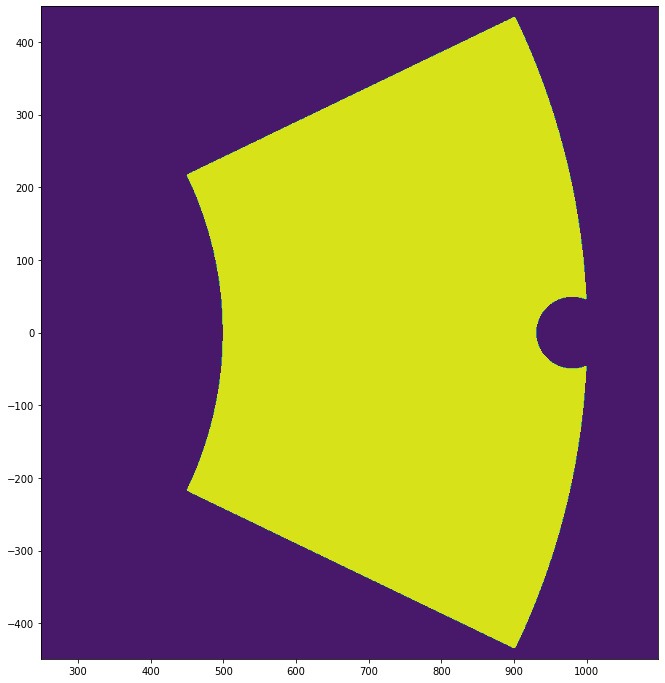

In [143]:
attractor = attractor_profile(R, height)
attractor.build(lambda pos: nholes_bad(pos[0], pos[1], pos[2], hr=50, from_edge=20),  N, cyl_sym=True)
attractor.plot_xy(upsample=1, save=True)

In [129]:
phis, newt, yuka = attractor.full_gravity(20, 5, lambdas=np.array([10e-6]), nphi=2000//7)

KeyboardInterrupt: 